# Importings

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import *
from sklearn.metrics import log_loss, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.9 MB/s eta 0:00:00


In [ ]:
def reading_data(path):
    train = pd.read_csv(path + 'Train%20(6).csv')
    test = pd.read_csv(path +'Test%20(4).csv')
    sub = pd.read_csv(path +'submission%20(5).csv')
    id = test['id']

    return train,test,sub,id

train,test,sub,id = reading_data(path='https://raw.githubusercontent.com/Asmaa6777/Vegetation-Mapping-/main/')

X_train = train.copy()
X_test = test.copy()
X_test = test.drop('id', axis=1)
X_train = X_train.drop('Target', axis=1)
X_train = X_train.drop('id', axis=1)
y_train = train['Target']


# Proccessing Pipeline
- isolation forest 
- 

In [ ]:
isolation_forest = IsolationForest(contamination=0.1)  
is_inlier = isolation_forest.fit_predict(X_train) 

# Keep only inliers
X_train_cleaned = X_train[is_inlier == 1]
y_train_cleaned = y_train[is_inlier == 1]

In [ ]:
num = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
 ])
cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

X_train_prepared = num.fit_transform(X_train_cleaned)
X_train_prepared = cat.fit_transform(X_train_prepared)
X_test_prepared = num.transform(X_test)
X_test_prepared = cat.transform(X_test_prepared)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_prepared , y_train_cleaned, test_size=0.2, random_state=42 )

In [ ]:
cat = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           class_weights=[1] * 45, 
                           random_seed=42)

cat_modle = cat.fit(X_train_prepared, y_train_cleaned, eval_set=(X_valid, y_valid), verbose=100)


0:	learn: 3.7372573	test: 3.7395708	best: 3.7395708 (0)	total: 2.56s	remaining: 21m 20s
100:	learn: 3.4007187	test: 3.4012757	best: 3.4012757 (100)	total: 3m 10s	remaining: 12m 30s
200:	learn: 3.3900507	test: 3.3907650	best: 3.3907650 (200)	total: 6m 7s	remaining: 9m 6s
300:	learn: 3.3793186	test: 3.3794833	best: 3.3794833 (300)	total: 8m 58s	remaining: 5m 56s
400:	learn: 3.3685364	test: 3.3679097	best: 3.3679097 (400)	total: 11m 47s	remaining: 2m 54s
499:	learn: 3.3580966	test: 3.3581326	best: 3.3581326 (499)	total: 14m 34s	remaining: 0us

bestTest = 3.358132597
bestIteration = 499



fix the val

In [ ]:
pred = cat_modle.predict_proba(X_train_prepared)

log_loss_value = log_loss(y_train_cleaned, pred)
print(f"Log Loss: {log_loss_value}")

Log Loss: 3.3580966386078246


In [ ]:
y_pred_proba = cat.predict_proba(X_valid)  
y_pred = cat.predict(X_valid)  

y_pred = cat_modle.predict(X_test_prepared)
y_pred_proba = cat_modle.predict_proba(X_test_prepared)

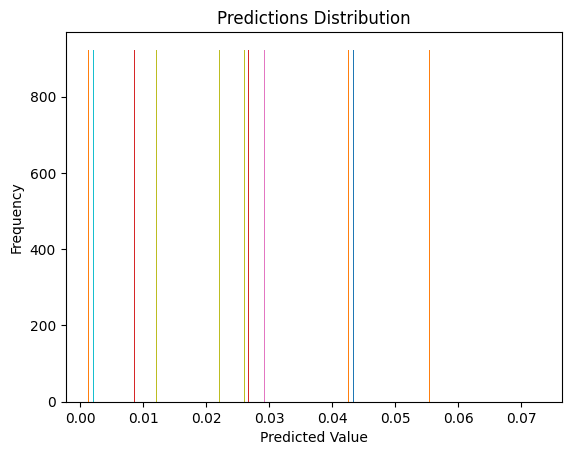

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred_proba, bins=30)
plt.title("Predictions Distribution")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()


**Submission**

In [ ]:
submission = pd.DataFrame({'id': id})
columns = [f'Target_{i}' for i in range(125)]
submission[columns] = 0.00001

y_pred_proba = cat_modle.predict_proba(X_test_prepared)

for i, class_label in enumerate(cat_modle.classes_):
    submission['Target_' + str(class_label)] = y_pred_proba[:, i]

submission.to_csv('../submissions/submission_part2.csv', index=False)